# Figures for paper

In [1]:
# import all revelant packages
from headers import *

## Intuition for the effect of Early Dark Energy (EDE)

In [3]:
params = {
          'output': 'mPk',         
          'P_k_max_h/Mpc': 40.,
          'z_pk': '0.0,10',
          'A_s': 2.10732e-9,
          'n_s': 0.96824,
          'h': 0.6770,
          'N_ur': 2.0328,
          'N_ncdm': 1,
          'm_ncdm': 0.06,
          'tau_reio': 0.0568,
          'omega_b': 0.02247,
          'omega_cdm': 0.11923}

EDE_params = {'log10z_c': 3.5,
              'fEDE': 0.05,
              'thetai_scf': 2.83,
              'Omega_Lambda':0.0,
              'Omega_fld':0,
              'Omega_scf':-1,
              'n_scf':3,
              'CC_scf':1,
              'scf_tuning_index':3,
              'scf_parameters':'1, 1, 1, 1, 1, 0.0',
              'attractor_ic_scf':'no'}

EDE = Class()
EDE.set(params)
EDE.compute()

In [4]:
kk = np.logspace(np.log10(0.005),np.log10(0.5),300)
pfid = np.array([EDE.pk_lin(k*params['h'],2.)*params['h']**3. for k in kk])

In [5]:
EDE.set(EDE_params)
EDE.compute()
#
EDE1,EDE2 = Class(),Class()
#
EDE1.set(params)
EDE1.set(EDE_params)
EDE1.set({'fEDE': 0.02})
EDE1.compute()
#
EDE2.set(params)
EDE2.set(EDE_params)
EDE2.set({'fEDE': 0.01})
EDE2.compute()

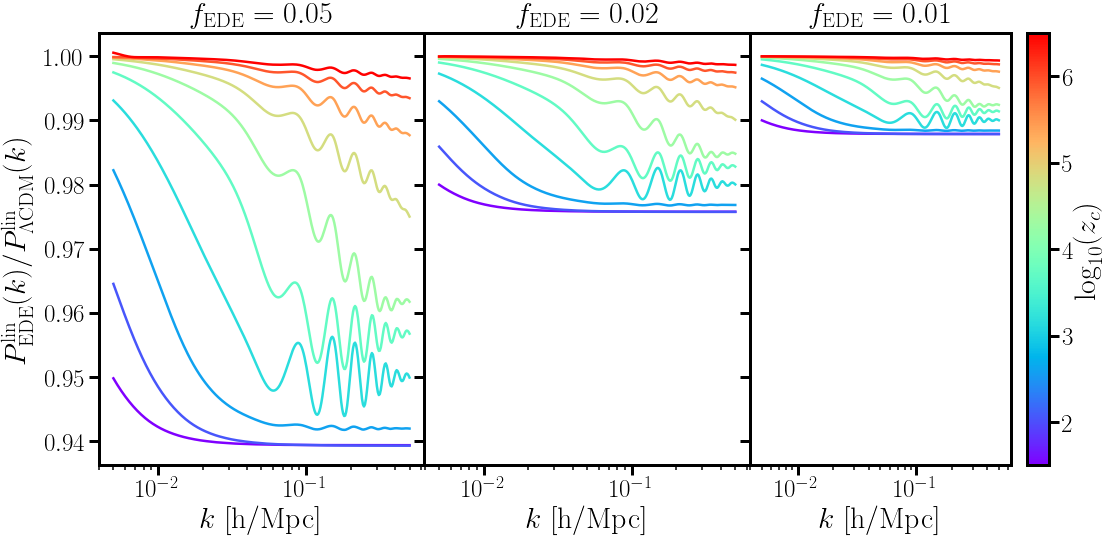

In [6]:
# for a fixed value of f_EDE, scan over log10(z_c) to gain an intuition for what scales change
log10z_cs = np.linspace(1.5,6.5,10)
norm = plt.Normalize()
greens = plt.cm.rainbow(norm([i for i in range(len(log10z_cs))]))

pmatter,pmatter1,pmatter2 = [],[],[]

fig, axs = plt.subplots(1, 3, figsize=(14,8), gridspec_kw={'hspace': 0.,'wspace':0.})

for i,log10z_c in enumerate(log10z_cs):
    EDE.set({'log10z_c':log10z_c})
    EDE.compute()
    EDE1.set({'log10z_c':log10z_c})
    EDE1.compute()
    EDE2.set({'log10z_c':log10z_c})
    EDE2.compute()
    pmatter.append(np.array([EDE.pk_lin(k*params['h'],2.)*params['h']**3. for k in kk]))
    pmatter1.append(np.array([EDE1.pk_lin(k*params['h'],2.)*params['h']**3. for k in kk]))
    pmatter2.append(np.array([EDE2.pk_lin(k*params['h'],2.)*params['h']**3. for k in kk]))

for i,log10z_c in enumerate(log10z_cs):
    axs[0].semilogx(kk,pmatter[i]/pfid, c=greens[i],lw=2.5)
    axs[1].semilogx(kk,pmatter1[i]/pfid, c=greens[i],lw=2.5)
    axs[2].semilogx(kk,pmatter2[i]/pfid, c=greens[i],lw=2.5)


#for i in range(3): axs[i].tick_params(direction='in')    
for i in range(1,3): axs[i].yaxis.set_ticklabels([])
axs[1].get_shared_y_axes().join(axs[0], axs[1])
axs[2].get_shared_y_axes().join(axs[0], axs[2])
axs[0].set_xlabel(r'$k$ [h/Mpc]')
axs[1].set_xlabel(r'$k$ [h/Mpc]')
axs[2].set_xlabel(r'$k$ [h/Mpc]')
axs[0].set_ylabel(r'$P^\text{lin}_\text{EDE}(k)/P^\text{lin}_{\Lambda\text{CDM}}(k)$')
axs[0].set_title(r'$f_\text{EDE}=0.05$')
axs[1].set_title(r'$f_\text{EDE}=0.02$')
axs[2].set_title(r'$f_\text{EDE}=0.01$')
plt.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=log10z_cs[0],vmax=log10z_cs[-1]), cmap=plt.cm.rainbow), label=r'$\log_{10}(z_c)$')
plt.savefig('figures/EDE_power_spectrum_varying_with_z_c.pdf',bbox_inches='tight')

# Derivatives

In [3]:
# Using halofit to estimate the nonlinear matter power spectrum
params = {
          'output': 'mPk',
          'P_k_max_h/Mpc': 40.,
          'non linear':'halofit', 
          'z_pk': '0.0,10',
          'A_s': 2.10732e-9,
          'n_s': 0.96824,
          'alpha_s': 0.,
          'h': 0.6770,
          'N_ur': 2.0328,
          'N_ncdm': 1,
          'm_ncdm': 0.06,
          'tau_reio': 0.0568,
          'omega_b': 0.02247,
          'omega_cdm': 0.11923}

cosmo = Class()
cosmo.set(params)
cosmo.compute()

In [4]:
exp = experiment(zmin=1., zmax=6., nbins=5, fsky=1., sigma_z=0.0, n=0.001, b=1.5)
forecast = fisherForecast(experiment=exp,cosmo=cosmo,params=params,khmin=5.e-4,khmax=1.,Nk=500,Nmu=200,velocileptors=True)

In [5]:
k = np.logspace(np.log10(5.e-3),np.log10(forecast.khmax),forecast.Nk)

## Plotting the "signal-to-noise" for the derivatives as a function of redshift

In [42]:
covariances = np.array([compute_covariance_matrix(forecast, i) for i in range(exp.nbins)])
covariances[:] *= 2.*forecast.dk*forecast.dmu/forecast.k
covariances[:] = np.sqrt(covariances[:])
sigma_kP = np.array([forecast.get_f_at_fixed_mu(covariances[i],0.) for i in range(exp.nbins)])

In [43]:
def get_dPdp(param):
   derivatives = np.array([forecast.compute_dPdp(param,exp.zcenters[i]) for i in range(exp.nbins)])
   der = np.array([forecast.get_f_at_fixed_mu(derivatives[i],0.) for i in range(exp.nbins)])
   return der

In [44]:
omega_b = get_dPdp('omega_b')
omega_cdm = get_dPdp('omega_cdm')
h = get_dPdp('h')
tau_reio = get_dPdp('tau_reio')
m_ncdm = get_dPdp('m_ncdm')
fEDE = get_dPdp('fEDE')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


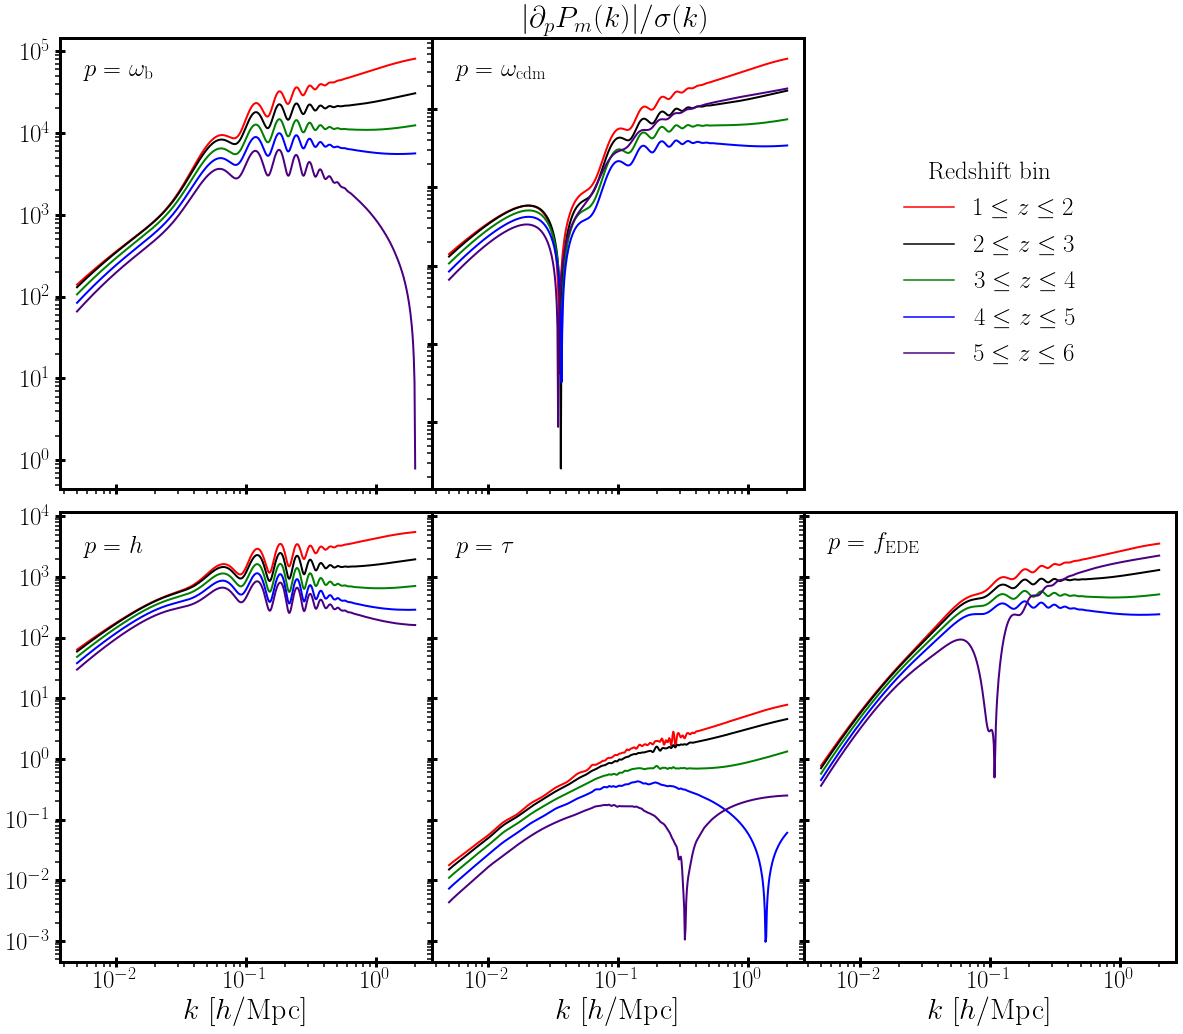

In [45]:
derivatives = [omega_b,omega_cdm,h,tau_reio,m_ncdm,fEDE]
colors = ['red','black','green','blue','indigo']
labels = [r'$1\leq z\leq2$',r'$2\leq z\leq3$',r'$3\leq z\leq4$',r'$4\leq z\leq5$',r'$5\leq z\leq 6$']
labels2 = [r'$\omega_\text{b}$',r'$\omega_\text{cdm}$',r'$h$',r'$\tau$',r'$M_\nu/1\text{ eV}$',r'$f_\text{EDE}$']

fig, axs = plt.subplots(2, 3, figsize=(20,17), gridspec_kw={'hspace': 0.05,'wspace':0.})

for i in range(exp.nbins): axs[0,0].loglog(k,np.abs(derivatives[0][i](k)/sigma_kP[i](k)),c=colors[i],lw=2)
for i in range(exp.nbins): axs[0,1].loglog(k,np.abs(derivatives[1][i](k)/sigma_kP[i](k)),c=colors[i],lw=2)
for i in range(exp.nbins): axs[1,0].loglog(k,np.abs(derivatives[2][i](k)/sigma_kP[i](k)),c=colors[i],lw=2)
for i in range(exp.nbins): axs[1,1].loglog(k,np.abs(derivatives[3][i](k)/sigma_kP[i](k)),c=colors[i],lw=2)
for i in range(exp.nbins): axs[1,2].loglog(k,np.abs(derivatives[5][i](k)/sigma_kP[i](k)),c=colors[i],lw=2)

axs[0,0].xaxis.set_ticklabels([])
axs[0,0].tick_params(direction='inout')
axs[0,0].legend(loc='upper left',frameon=False,title=r'$p= $'+' '+labels2[0])
axs[0,0].get_shared_x_axes().join(axs[0,0], axs[1,0])

axs[0,1].yaxis.set_ticklabels([])
axs[0,1].xaxis.set_ticklabels([])
axs[0,1].tick_params(direction='inout')
axs[0,1].legend(loc='upper left',frameon=False,title=r'$p= $'+' '+labels2[1])
axs[0,1].get_shared_x_axes().join(axs[0,1], axs[1,1])
axs[0,1].get_shared_y_axes().join(axs[0,1], axs[0,0])
axs[0,1].set_title(r'$|\partial_p P_m(k)|/\sigma(k)$')

axs[0,2].axis('off')
for i in range(exp.nbins): axs[0,2].semilogx([],[],c=colors[i],label=labels[i])
axs[0,2].legend(loc='center',frameon=False,ncol=1,title='Redshift bin')

axs[1,0].tick_params(direction='inout')
axs[1,0].set_xlabel(r'$k$ [$h$/Mpc]')
axs[1,0].legend(loc='upper left',frameon=False,title=r'$p= $'+' '+labels2[2])

axs[1,1].yaxis.set_ticklabels([])
axs[1,1].tick_params(direction='inout')
axs[1,1].set_xlabel(r'$k$ [$h$/Mpc]')
axs[1,1].legend(loc='upper left',frameon=False,title=r'$p= $'+' '+labels2[3])
axs[1,1].get_shared_y_axes().join(axs[1,1], axs[1,0])

axs[1,2].yaxis.set_ticklabels([])
axs[1,2].tick_params(direction='inout')
axs[1,2].set_xlabel(r'$k$ [$h$/Mpc]')
axs[1,2].legend(loc='upper left',frameon=False,title=r'$p= $'+' '+labels2[5])
axs[1,2].get_shared_y_axes().join(axs[1,2], axs[1,0])

plt.savefig('figures/derivatives_SNR.pdf')

## Checking that the derivatives are stable

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


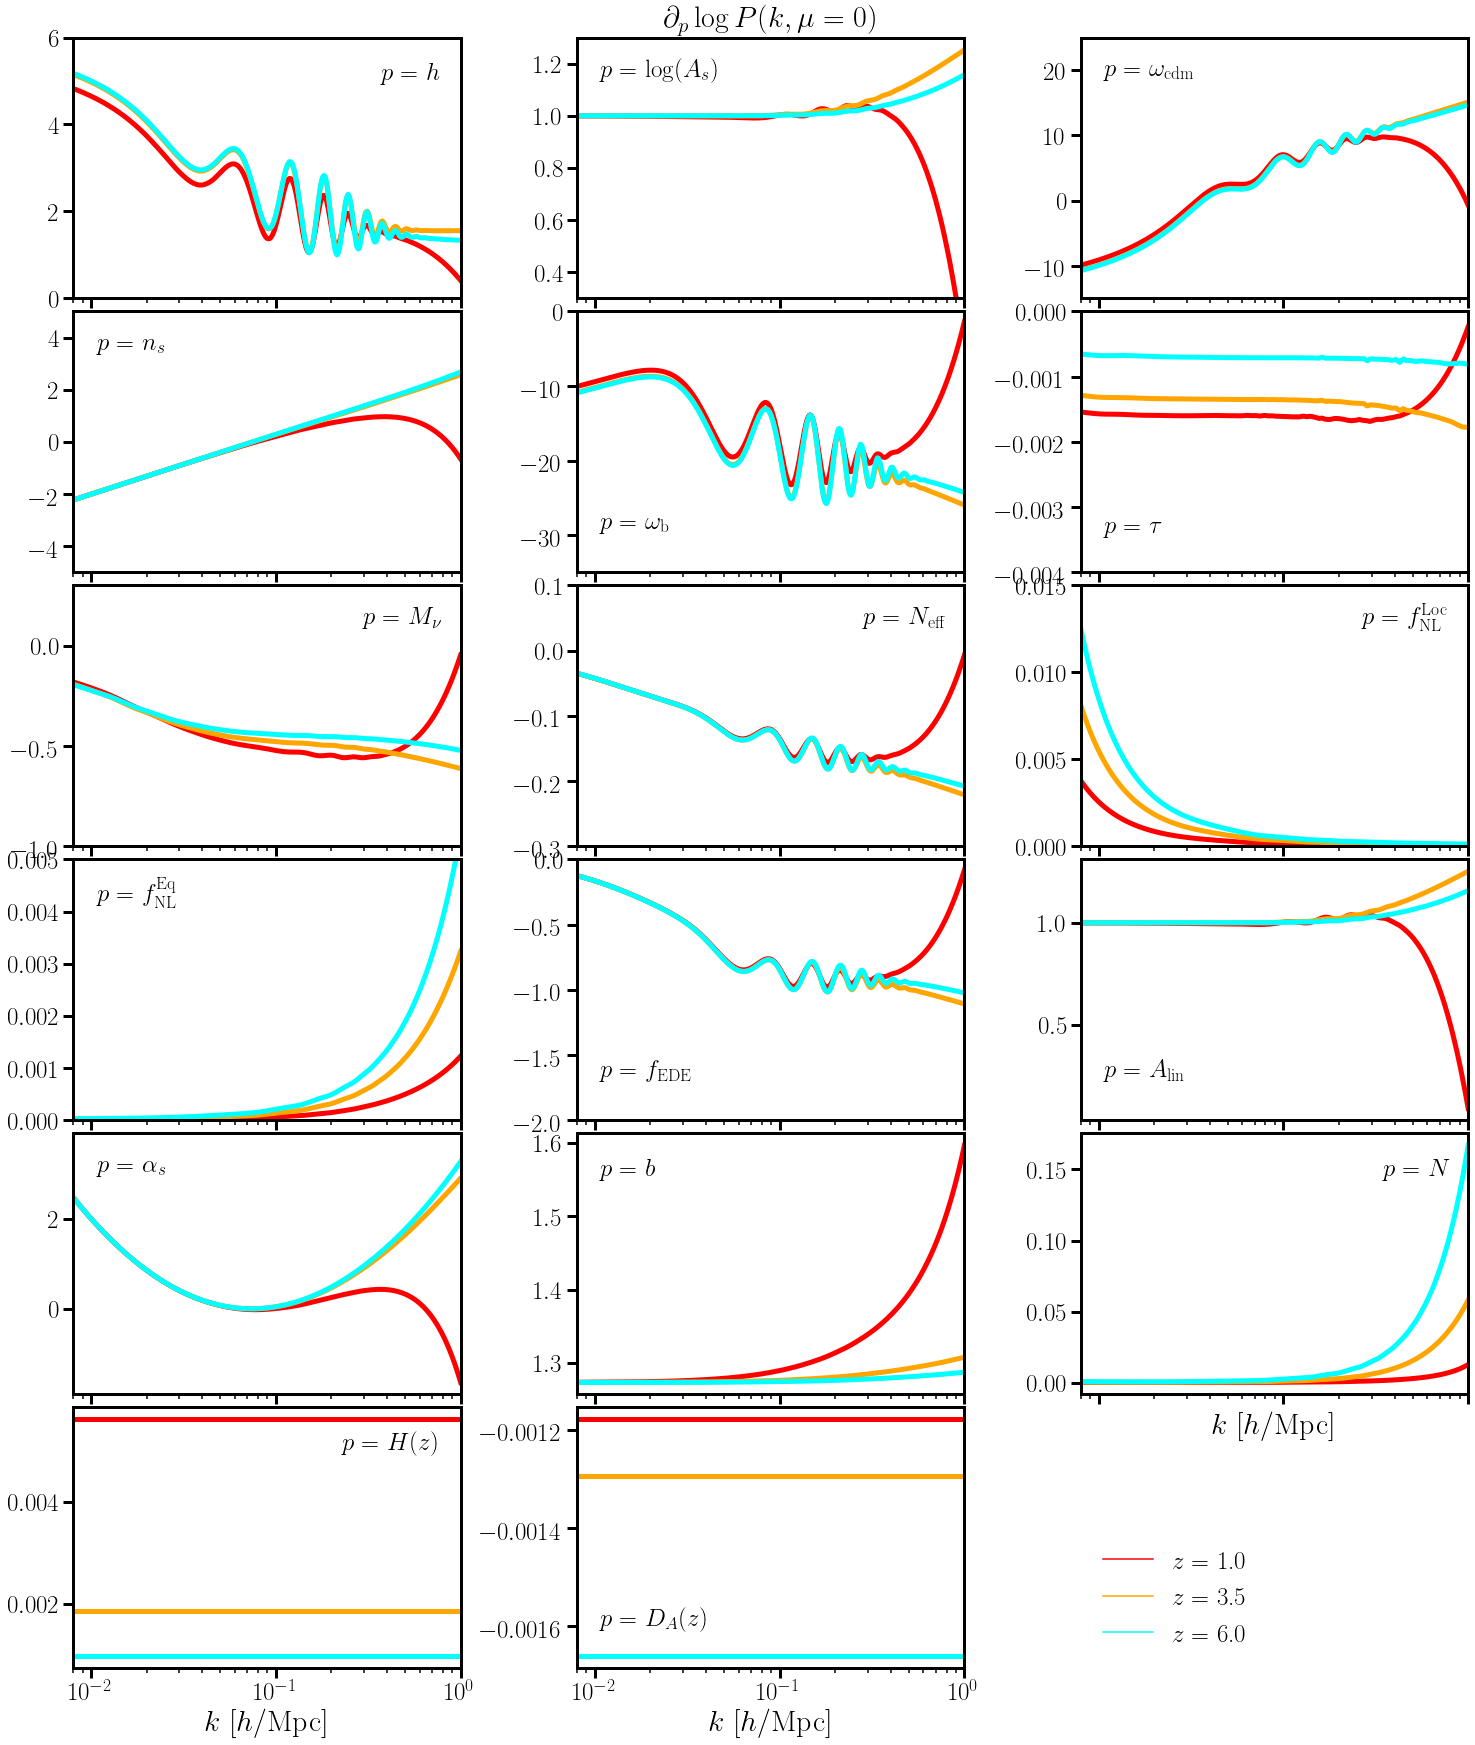

In [6]:
import math

parameters = ['h',  'log(A_s)','omega_cdm',  'n_s', 'omega_b','tau_reio','m_ncdm','N_ur','f_NL','f_NL_eq','fEDE','A_lin','alpha_s','b','N','Hz','Da']
labels = [r'$h$',r'$\log(A_s)$',r'$\omega_\text{cdm}$',r'$n_s$',r'$\omega_\text{b}$',r'$\tau$',\
          r'$M_\nu$',r'$N_\text{eff}$',r'$f_\text{NL}^\text{Loc}$',r'$f_\text{NL}^\text{Eq}$',\
          r'$f_\text{EDE}$',r'$A_\text{lin}$',r'$\alpha_s$',r'$b$',r'$N$',r'$H(z)$',r'$D_A(z)$']

zs = np.array([1.,3.5,6.])
colors = np.array(['red','orange','cyan'])

N = math.ceil(len(parameters)/3.)
fig, axs = plt.subplots(N, 3, figsize=(25,30), gridspec_kw={'hspace': 0.05,'wspace':0.3})

def draw_stuff(z,c):
   p_fid = compute_tracer_power_spectrum(forecast, z)
   p_fid = forecast.get_f_at_fixed_mu(p_fid,0.)

   for i,p in enumerate(parameters):
      i1,i2 = i//3,i%3
      dPdp = forecast.compute_dPdp(p, z, five_point=True)
      dPdp = forecast.get_f_at_fixed_mu(dPdp,0.)
      axs[i1,i2].semilogx(k,dPdp(k)/p_fid(k),c=c,lw=5)

for j,z in enumerate(zs): draw_stuff(z,colors[j])

for i,p in enumerate(parameters):
   i1,i2 = i//3,i%3
   axs[i1,i2].legend(loc=0,frameon=False,title=r'$p= $'+' '+labels[i])
    
for i in range(N):
   for j in range(3):
      axs[i,j].set_xlim(8.e-3,1.0)
      if i != N-1: 
         axs[i,j].get_shared_x_axes().join(axs[i,j], axs[N-1,j])
         axs[i,j].xaxis.set_ticklabels([])
      if i == N-1:
         if i*3.+j > len(parameters)-1: 
            axs[i,j].axis('off')
            axs[i-1,j].set_xlabel(r'$k$ [$h$/Mpc]')
         else:
            axs[i,j].set_xlabel(r'$k$ [$h$/Mpc]')
            
axs[0,1].set_title(r'$\partial_p \log P(k,\mu=0)$')

for i,z in enumerate(zs): axs[N-1,2].plot([],[],c=colors[i],label=r'$z=$'+' '+str(z))
axs[N-1,2].legend(loc='lower left', frameon=False)

axs[0,0].set_ylim(0,6)
axs[0,1].set_ylim(0.3,1.3)
axs[0,2].set_ylim(-15,25)

axs[1,0].set_ylim(-5,5)
axs[1,1].set_ylim(-35,0)
axs[1,2].set_ylim(-0.004,0.)

axs[2,0].set_ylim(-1.,0.3)
axs[2,1].set_ylim(-.3,0.1)
axs[2,2].set_ylim(0,0.015)

axs[3,0].set_ylim(0,0.005)
axs[3,1].set_ylim(-2,0)

plt.savefig('figures/derivatives.pdf',bbox_inches='tight')

## Checking consistency with halofit

In [7]:
# Using halofit to estimate the nonlinear matter power spectrum
params2 = {
          'output': 'mPk',
          'P_k_max_h/Mpc': 40.,
          'non linear':'halofit', 
          'z_pk': '0.0,10',
          'A_s': 2.10732e-9,
          'n_s': 0.96824,
          'alpha_s': 0.,
          'h': 0.6770,
          'N_ur': 2.0328,
          'N_ncdm': 1,
          'm_ncdm': 0.06,
          'tau_reio': 0.0568,
          'omega_b': 0.02247,
          'omega_cdm': 0.11923,
          'Omega_k': 0.}

cosmo2 = Class()
cosmo2.set(params2)
cosmo2.compute()

In [8]:
exp2 = experiment(zmin=1., zmax=6., nbins=5, fsky=1., sigma_z=0.0, n=0.001, b=1.5)

In [9]:
forecast2 = fisherForecast(experiment=exp2,cosmo=cosmo2,params=params2,khmin=5.e-4,khmax=1.,Nk=500,Nmu=200,velocileptors=False)

In [10]:
z=6.

omega_cdm = forecast.compute_dPdp('omega_cdm', z, five_point=True)
#omega_cdm = forecast.get_f_at_fixed_mu(omega_cdm,0.)
omega_b = forecast.compute_dPdp('omega_b', z, five_point=True)
#omega_b = forecast.get_f_at_fixed_mu(omega_b,0.)
n_s = forecast.compute_dPdp('n_s', z, five_point=True)
#n_s = forecast.get_f_at_fixed_mu(n_s,0.)
f_EDE = forecast.compute_dPdp('fEDE', z,five_point=True)
#f_EDE = forecast.get_f_at_fixed_mu(f_EDE,0.)

omega_cdm2 = forecast2.compute_dPdp('omega_cdm', z, five_point=True)
#omega_cdm2 = forecast2.get_f_at_fixed_mu(omega_cdm2,0.)
omega_b2 = forecast2.compute_dPdp('omega_b', z, five_point=True)
#omega_b2 = forecast2.get_f_at_fixed_mu(omega_b2,0.)
n_s2 = forecast2.compute_dPdp('n_s', z,five_point=True)
#n_s2 = forecast2.get_f_at_fixed_mu(n_s2,0.)
f_EDE2 = forecast2.compute_dPdp('fEDE', z,five_point=True)
#f_EDE2 = forecast2.get_f_at_fixed_mu(f_EDE2,0.)

In [11]:
p_fid_p = compute_tracer_power_spectrum(forecast, z)
p_fid = forecast.get_f_at_fixed_mu(p_fid_p,0.)

p_fid2_p = compute_tracer_power_spectrum(forecast2, z)
p_fid2 = forecast2.get_f_at_fixed_mu(p_fid2_p,0.)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


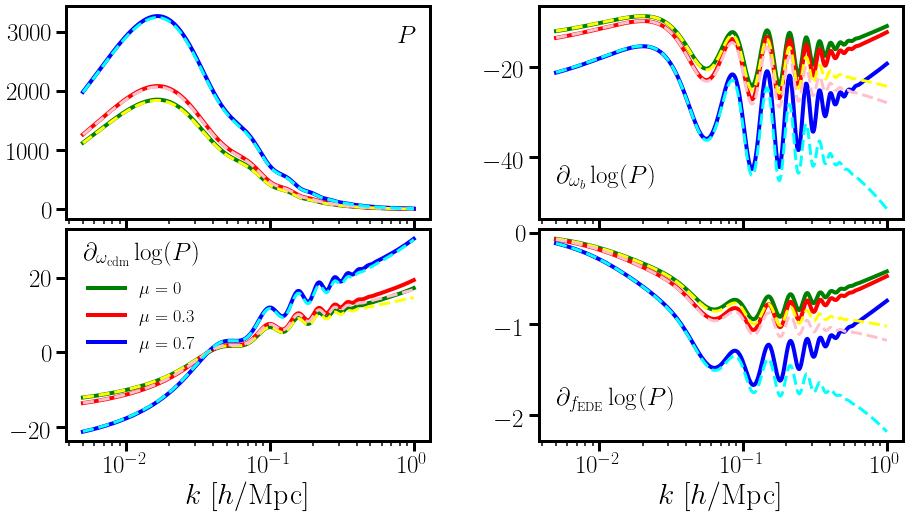

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15,8), gridspec_kw={'hspace': 0.05,'wspace':0.3})

axs[1,0].semilogx(k,forecast2.get_f_at_fixed_mu(omega_cdm2,0.)(k)/p_fid2(k),lw=4.,c='green',label=r'$\mu=0$')
axs[1,0].semilogx(k,forecast2.get_f_at_fixed_mu(omega_cdm2,0.3)(k)/p_fid2(k),lw=4.,c='red',label=r'$\mu=0.3$')
axs[1,0].semilogx(k,forecast2.get_f_at_fixed_mu(omega_cdm2,0.7)(k)/p_fid2(k),lw=4.,c='blue',label=r'$\mu=0.7$')
#
axs[1,0].semilogx(k,forecast.get_f_at_fixed_mu(omega_cdm,0.)(k)/p_fid(k),lw=3.,c='yellow',ls='--')
axs[1,0].semilogx(k,forecast.get_f_at_fixed_mu(omega_cdm,0.3)(k)/p_fid(k),lw=3.,c='pink',ls='--')
axs[1,0].semilogx(k,forecast.get_f_at_fixed_mu(omega_cdm,0.7)(k)/p_fid(k),lw=3.,c='cyan',ls='--')


axs[0,1].semilogx(k,forecast2.get_f_at_fixed_mu(omega_b2,0.)(k)/p_fid2(k),lw=4.,c='green')
axs[0,1].semilogx(k,forecast2.get_f_at_fixed_mu(omega_b2,0.3)(k)/p_fid2(k),lw=4.,c='red')
axs[0,1].semilogx(k,forecast2.get_f_at_fixed_mu(omega_b2,0.7)(k)/p_fid2(k),lw=4.,c='blue')
#
axs[0,1].semilogx(k,forecast.get_f_at_fixed_mu(omega_b,0.)(k)/p_fid(k),lw=3.,c='yellow',ls='--')
axs[0,1].semilogx(k,forecast.get_f_at_fixed_mu(omega_b,0.3)(k)/p_fid(k),lw=3.,c='pink',ls='--')
axs[0,1].semilogx(k,forecast.get_f_at_fixed_mu(omega_b,0.7)(k)/p_fid(k),lw=3.,c='cyan',ls='--')


axs[0,0].semilogx(k,forecast2.get_f_at_fixed_mu(p_fid2_p,0.)(k),lw=4.,c='green')
axs[0,0].semilogx(k,forecast2.get_f_at_fixed_mu(p_fid2_p,0.3)(k),lw=4.,c='red')
axs[0,0].semilogx(k,forecast2.get_f_at_fixed_mu(p_fid2_p,0.7)(k),lw=4.,c='blue')
#
axs[0,0].semilogx(k,forecast.get_f_at_fixed_mu(p_fid_p,0.)(k),lw=3.,c='yellow',ls='--')
axs[0,0].semilogx(k,forecast.get_f_at_fixed_mu(p_fid_p,0.3)(k),lw=3.,c='pink',ls='--')
axs[0,0].semilogx(k,forecast.get_f_at_fixed_mu(p_fid_p,0.7)(k),lw=3.,c='cyan',ls='--')


axs[1,1].semilogx(k,forecast2.get_f_at_fixed_mu(f_EDE2,0.)(k)/p_fid2(k),lw=4.,c='green')
axs[1,1].semilogx(k,forecast2.get_f_at_fixed_mu(f_EDE2,0.3)(k)/p_fid2(k),lw=4.,c='red')
axs[1,1].semilogx(k,forecast2.get_f_at_fixed_mu(f_EDE2,0.7)(k)/p_fid2(k),lw=4.,c='blue')
#
axs[1,1].semilogx(k,forecast.get_f_at_fixed_mu(f_EDE,0.)(k)/p_fid(k),lw=3.,c='yellow',ls='--')
axs[1,1].semilogx(k,forecast.get_f_at_fixed_mu(f_EDE,0.3)(k)/p_fid(k),lw=3.,c='pink',ls='--')
axs[1,1].semilogx(k,forecast.get_f_at_fixed_mu(f_EDE,0.7)(k)/p_fid(k),lw=3.,c='cyan',ls='--')

axs[0,0].legend(loc=0,fontsize='small',frameon=False,title=r'$P$')
axs[0,1].legend(loc=0,fontsize='small',frameon=False,title=r'$\partial_{\omega_b}\log(P)$')
axs[1,0].legend(loc=0,fontsize='small',frameon=False,title=r'$\partial_{\omega_\text{cdm}}\log(P)$')
axs[1,1].legend(loc=0,fontsize='small',frameon=False,title=r'$\partial_{f_\text{EDE}}\log(P)$')


axs[0,0].xaxis.set_ticklabels([])
axs[0,1].xaxis.set_ticklabels([])
axs[1,0].set_xlabel(r'$k$ [$h$/Mpc]')
axs[1,1].set_xlabel(r'$k$ [$h$/Mpc]')

plt.savefig('figures/velocileptors_vs_halofit.pdf',bbox_inches='tight')

## Cool way of looking at degeneracies

In [9]:
# Using halofit to estimate the nonlinear matter power spectrum
params3 = {
          'output': 'mPk',
          'P_k_max_h/Mpc': 40.,
          'non linear':'halofit', 
          'z_pk': '0.0,10',
          'A_s': 2.10732e-9,
          'n_s': 0.96824,
          'alpha_s': 0.,
          'h': 0.6770,
          'N_ur': 2.0328,
          'N_ncdm': 1,
          'm_ncdm': 0.06,
          'tau_reio': 0.0568,
          'omega_b': 0.02247,
          'omega_cdm': 0.11923,
          'Omega_k': 0.}

cosmo3 = Class()
cosmo3.set(params3)
cosmo3.compute()
exp3 = experiment(zmin=1., zmax=6., nbins=5, fsky=1., sigma_z=0.0, n=0.001, b=1.5)
forecast3 = fisherForecast(experiment=exp3,cosmo=cosmo3,params=params3,khmin=5.e-3,khmax=1.,Nk=500,Nmu=200,linear=True)

In [10]:
forecast.marg_params = marg_params = np.array(['h','log(A_s)','omega_cdm','n_s','omega_b','tau_reio','b','N'])
forecast3.marg_params = marg_params = np.array(['h','log(A_s)','omega_cdm','n_s','omega_b','tau_reio','b','N'])

In [13]:
F = [forecast.compute_Fisher_matrix_for_specific_zbin(i) for i in range(5)]
F3 = [forecast3.compute_Fisher_matrix_for_specific_zbin(i) for i in range(5)]

Text(0.5, 1.0, 'linear')

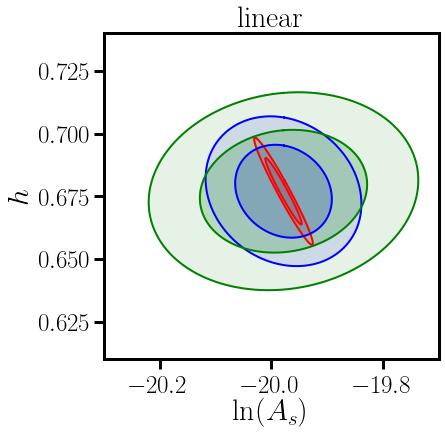

In [43]:
FID_VAL = np.array([0.6770,np.log(2.10732e-9),0.11923,0.96824,0.02247,0.0568])
LABELS = np.array([r'$h$',r'$\ln(A_s)$',r'$\omega_\text{cdm}$',r'$n_s$',r'$\omega_\text{b}$',r'$\tau$'])

plt.figure(figsize=(6,6))

def plot_ellipse(F,i,j,c,z,ls,lw):
   alphas = [0.1,0.2]
   Finv = np.linalg.inv(F)
   Ginv = np.array([[Finv[i,i],Finv[i,j]],[Finv[i,j],Finv[j,j]]])
   G = np.linalg.inv(Ginv)
   eigenvals,S = np.linalg.eig(G)
   D = np.diag(eigenvals)
   # find the solution of the ellipse in the diagonal basis
   theta = np.linspace(0.,2.*np.pi,1000)
   for k,f in enumerate(np.array([0.167,0.434])):
      xprime = np.cos(theta) / np.sqrt(f * D[0,0])
      yprime = np.sin(theta) / np.sqrt(f * D[1,1])
      # transform back to the parameter basis
      x,y = np.dot(S, np.array([xprime,yprime]))
      fid_val1 = FID_VAL[i]
      fid_val2 = FID_VAL[j]
      x += fid_val1
      y += fid_val2
      plt.fill(y,x,c=c,alpha=alphas[k])
      if k == 0: plt.plot([],[],c=c,label=str(z))
      plt.plot(y,x,c=c,lw=lw,ls=ls)
      plt.xlabel(LABELS[j])
      plt.ylabel(LABELS[i])

plot_ellipse(F3[0],0,1,z=forecast3.experiment.zcenters[0],c='red',ls='-',lw=2)
plot_ellipse(F3[3],0,1,z=forecast3.experiment.zcenters[3],c='blue',ls='-',lw=2)
plot_ellipse(F3[4],0,1,z=forecast3.experiment.zcenters[4],c='green',ls='-',lw=2)


plt.ylim(0.61,0.74)
plt.xlim(-20.3,-19.7)
plt.title('linear')

Text(0.5, 1.0, 'non-linear')

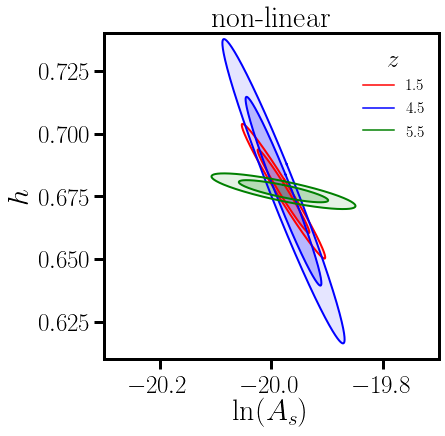

In [41]:
plt.figure(figsize=(6,6))

plot_ellipse(F[0],0,1,z=forecast.experiment.zcenters[0],c='red',ls='-',lw=2)
plot_ellipse(F[3],0,1,z=forecast.experiment.zcenters[3],c='blue',ls='-',lw=2)
plot_ellipse(F[4],0,1,z=forecast.experiment.zcenters[4],c='green',ls='-',lw=2)

plt.legend(loc='upper right',fontsize='x-small',title=r'$z$',ncol=1,frameon=False)

plt.ylim(0.61,0.74)
plt.xlim(-20.3,-19.7)
plt.title('non-linear')

# Megamapper
Assuming a redshift range of $z\in[2,5]$ divided into bins with width $\Delta z=0.5$, $f_\text{sky}=0.5$, and the LBG bias and number densities from Wilson & White 2019.

In [3]:
# Using halofit to estimate the nonlinear matter power spectrum
megaParams = {
          'output': 'mPk',
          'P_k_max_h/Mpc': 40.,
          'non linear':'halofit', 
          'z_pk': '0.0,10',
          'A_s': 2.10732e-9,
          'n_s': 0.96824,
          'alpha_s': 0.,
          'h': 0.6770,
          'N_ur': 2.0328,
          'N_ncdm': 1,
          'm_ncdm': 0.06,
          'tau_reio': 0.0568,
          'omega_b': 0.02247,
          'omega_cdm': 0.11923,
          'Omega_k': 0.}

megaCosmo = Class()
megaCosmo.set(megaParams)
megaCosmo.compute()

In [4]:
# Since we sample LBG galaxies, set LBG=True. This tells fishlss to use the LBG bias and noise models.
# For now I'm ignoring photo-z errors, so I set sigma_z=0
megaMapper = experiment(zmin=2., zmax=5., nbins=6, fsky=0.5, sigma_z=0.0, LBG=True)
# Create a forecasting object for Megamapper
megaCast = fisherForecast(experiment=megaMapper,cosmo=megaCosmo,params=megaParams,khmin=5.e-4,\
                          khmax=1.,Nk=200,Nmu=200,velocileptors=True)
megaCast.marg_params = np.array(['h','log(A_s)','omega_cdm','n_s','omega_b','tau_reio','fEDE','b','N','m_ncdm','f_NL','N_ur','f_NL_eq','A_lin','alpha_s','Hz','Da'])

In [15]:
F_megamapper,Fi_megamapper = megaCast.compute_Fisher_matrix(five_point=True)

In [16]:
np.savetxt('output/F0_megamapper.txt',Fi_megamapper[0])
np.savetxt('output/F1_megamapper.txt',Fi_megamapper[1])
np.savetxt('output/F2_megamapper.txt',Fi_megamapper[2])
np.savetxt('output/F3_megamapper.txt',Fi_megamapper[3])
np.savetxt('output/F4_megamapper.txt',Fi_megamapper[4])
np.savetxt('output/F5_megamapper.txt',Fi_megamapper[5])

np.savetxt('output/F_megamapper.txt',F_megamapper)

# PUMA
Assuming a redshift range of $z\in[2,6]$ divided into bins with width $\Delta z=0.5$, $f_\text{sky}=0.5$, the HI bias from Castorina, and the HI noise model from Slosar.

In [5]:
# Using halofit to estimate the nonlinear matter power spectrum
pumaParams = {
          'output': 'mPk',
          'P_k_max_h/Mpc': 40.,
          'non linear':'halofit', 
          'z_pk': '0.0,10',
          'A_s': 2.10732e-9,
          'n_s': 0.96824,
          'alpha_s': 0.,
          'h': 0.6770,
          'N_ur': 2.0328,
          'N_ncdm': 1,
          'm_ncdm': 0.06,
          'tau_reio': 0.0568,
          'omega_b': 0.02247,
          'omega_cdm': 0.11923,
          'Omega_k': 0.}

pumaCosmo = Class()
pumaCosmo.set(pumaParams)
pumaCosmo.compute()

In [6]:
PUMA = experiment(zmin=2., zmax=6., nbins=8, fsky=0.5, sigma_z=0.0, HI=True)
pumaCast = fisherForecast(experiment=PUMA,cosmo=pumaCosmo,params=pumaParams,khmin=5.e-4,\
                          khmax=1.,Nk=200,Nmu=200,velocileptors=True)
pumaCast.marg_params = np.array(['h','log(A_s)','omega_cdm','n_s','omega_b','tau_reio','b','N','fEDE','m_ncdm','f_NL','N_ur','f_NL_eq','A_lin','alpha_s','Hz','Da','Tb'])

In [5]:
#F_puma,Fi_puma = pumaCast.compute_Fisher_matrix(five_point=True)

In [6]:
F0_puma = pumaCast.compute_Fisher_matrix_for_specific_zbin(0,five_point=True)

In [12]:
F1_puma = pumaCast.compute_Fisher_matrix_for_specific_zbin(1,five_point=True)

In [17]:
F2_puma = pumaCast.compute_Fisher_matrix_for_specific_zbin(2,five_point=True)

In [23]:
F3_puma = pumaCast.compute_Fisher_matrix_for_specific_zbin(3,five_point=True)

In [25]:
F4_puma = pumaCast.compute_Fisher_matrix_for_specific_zbin(4,five_point=True)

In [27]:
F5_puma = pumaCast.compute_Fisher_matrix_for_specific_zbin(5,five_point=True)

In [29]:
F6_puma = pumaCast.compute_Fisher_matrix_for_specific_zbin(6,five_point=True)

In [31]:
F7_puma = pumaCast.compute_Fisher_matrix_for_specific_zbin(7,five_point=True)

In [37]:
F_puma = F0_puma + F1_puma + F2_puma + F3_puma + F4_puma + F5_puma + F6_puma + F7_puma

In [38]:
#np.savetxt('output/F0_puma.txt',Fi_puma[0])
#np.savetxt('output/F1_puma.txt',Fi_puma[1])
#np.savetxt('output/F2_puma.txt',Fi_puma[2])
#np.savetxt('output/F3_puma.txt',Fi_puma[3])
#np.savetxt('output/F4_puma.txt',Fi_puma[4])
#np.savetxt('output/F5_puma.txt',Fi_puma[5])
#np.savetxt('output/F6_puma.txt',Fi_puma[6])
#np.savetxt('output/F7_puma.txt',Fi_puma[7])

np.savetxt('output/F_puma.txt',F_puma)

# DESI

In [7]:
desiParams = {
          'output': 'mPk',
          'P_k_max_h/Mpc': 40.,
          'non linear':'halofit', 
          'z_pk': '0.0,10',
          'A_s': 2.10732e-9,
          'n_s': 0.96824,
          'alpha_s': 0.,
          'h': 0.6770,
          'N_ur': 2.0328,
          'N_ncdm': 1,
          'm_ncdm': 0.06,
          'tau_reio': 0.0568,
          'omega_b': 0.02247,
          'omega_cdm': 0.11923}

desiCosmo = Class()
desiCosmo.set(desiParams)
desiCosmo.compute()

In [8]:
DESI = experiment(zmin=0.6, zmax=1.7, nbins=5, fsky=0.5, sigma_z=0.0, ELG=True)
desiCast = fisherForecast(experiment=DESI,cosmo=desiCosmo,params=desiParams,khmin=5.e-4,\
                          khmax=1.,Nk=200,Nmu=200,velocileptors=False)

# Figure of merit

In [9]:
# CMB N_modes
params_CMB = {'output': 'tCl, pCl, lCl', 'modes':'s,t',
    'l_max_scalars': 10000, 'l_max_tensors': 1000,
    'lensing': 'yes',
    'r': 0.01,
    'A_s': 2.10732e-9,
    'n_s': 0.96824, 
    'h': 0.6770,
    'N_ur': 2.0328,
    'N_ncdm': 1,
    'm_ncdm': 0.06,
    'tau_reio': 0.0568,
    'omega_b': 0.022447,
    'omega_cdm': 0.11923}  

cosmo_CMB = Class()
cosmo_CMB.set(params_CMB)
cosmo_CMB.compute()
cls = cosmo_CMB.raw_cl(10000)

In [10]:
Tcmb = 2.7255e6 #muK

def N(l,noise,FWHM):
   noise *= 0.000290888 # convert muK-arcmin to muK-radians
   FWHM *= 0.000290888 # convert arcmin to radians
   return noise**2. * np.exp(FWHM**2. * l**2. / (8.*np.log(2.)))

def covariance(l,noise,FWHM):
   tt = cls['tt'][l] * Tcmb**2.
   if l>3000: tt += 1.e6
   te = np.abs(cls['te'][l]) * Tcmb**2.
   ee = cls['ee'][l] * Tcmb**2.
   n = N(l,noise,FWHM)
   C = np.array([[ (tt+n)**2. , (tt+n)*te                     , te**2.          ],
                 [ (tt+n)*te  , (te**2 + (tt+n)*(ee+2.*n))/2. , (ee+2.*n)*te    ],
                 [ te**2.     , (ee+2.*n)*te                  , (ee+2.*n)**2.   ]])
   C /= (2.*l+1.)/2.
   return C

def N_modes_CMB(noise,FWHM):
   '''
   noise in muK-arcmin
   FWHM in arcmin
   '''
   ell = cls['ell'][2:]
   def F_AA(l):
      C = covariance(l,noise,FWHM)
      Cinv = np.linalg.inv(C)
      mu = np.array([cls['tt'][l],cls['te'][l],cls['ee'][l]]) * Tcmb**2.
      return np.dot(np.dot(mu,Cinv),mu)
   result = sum([F_AA(l) for l in ell])
   return 2.*result

In [11]:
# cosmic variance limit
cv = experiment(zmin=2., zmax=6., nbins=6, fsky=0.5, sigma_z=0.0, b=10., custom_n=True, n=10000.)
cv_f = fisherForecast(experiment=cv,cosmo=megaCosmo,params=megaParams,khmin=5.e-3,\
                          khmax=1.,Nk=200,Nmu=200)

In [12]:
NGH1 = experiment(zmin=2., zmax=5.9, nbins=6, fsky=0.5, sigma_z=0.0, LBG=True, custom_n=True, n=0.001)
NGH1_f = fisherForecast(experiment=NGH1,cosmo=megaCosmo,params=megaParams,khmin=5.e-3,\
                          khmax=1.,Nk=200,Nmu=200)

NGH2 = experiment(zmin=2., zmax=5.9, nbins=6, fsky=0.5, sigma_z=0.0, LBG=True, custom_n=True, n=0.01)
NGH2_f = fisherForecast(experiment=NGH2,cosmo=megaCosmo,params=megaParams,khmin=5.e-3,\
                          khmax=1.,Nk=200,Nmu=200)

NGH3 = experiment(zmin=2., zmax=5.9, nbins=6, fsky=0.5, sigma_z=0.0, LBG=True, custom_n=True, n=0.1)
NGH3_f = fisherForecast(experiment=NGH3,cosmo=megaCosmo,params=megaParams,khmin=5.e-3,\
                          khmax=1.,Nk=200,Nmu=200)

NGH4 = experiment(zmin=2., zmax=5.9, nbins=6, fsky=0.5, sigma_z=0.0, LBG=True, custom_n=True, n=0.1)
NGH4_f = fisherForecast(experiment=NGH4,cosmo=megaCosmo,params=megaParams,khmin=5.e-3,\
                          khmax=1.,Nk=200,Nmu=200)

In [13]:
pumaCast.velocileptors = False
megaCast.velocileptors = False

In [14]:
mega_zmax = np.linspace(2.2,5.9,50)
puma_zmax = np.linspace(2.2,6.,50)

mega_Nmodes = np.array([megaCast.Nmodes(2.,z,50) for z in mega_zmax])
#mega_kpar_Nmodes = np.array([megaCast.Nmodes(2.,z,50,kpar=0.01) for z in mega_zmax])
puma_Nmodes = np.array([pumaCast.Nmodes(2.,z,50) for z in puma_zmax])

NGH1_Nmodes = np.array([NGH1_f.Nmodes(2.,z,50) for z in mega_zmax])
NGH2_Nmodes = np.array([NGH2_f.Nmodes(2.,z,50) for z in mega_zmax])
NGH3_Nmodes = np.array([NGH3_f.Nmodes(2.,z,50) for z in mega_zmax])
NGH4_Nmodes = np.array([NGH4_f.Nmodes(2.,z,50) for z in mega_zmax])

cv_Nmodes = np.array([cv_f.Nmodes(2.,z,50) for z in puma_zmax])
upper_limit = np.ones(len(puma_zmax))*(1.e23)

SO = N_modes_CMB(7.,1.4)/2.
S4 = N_modes_CMB(1.5,1.4)/2.

In [15]:
# adding DESI to the mix 
desi_Nmodes = desiCast.Nmodes(0.6,1.7,60)

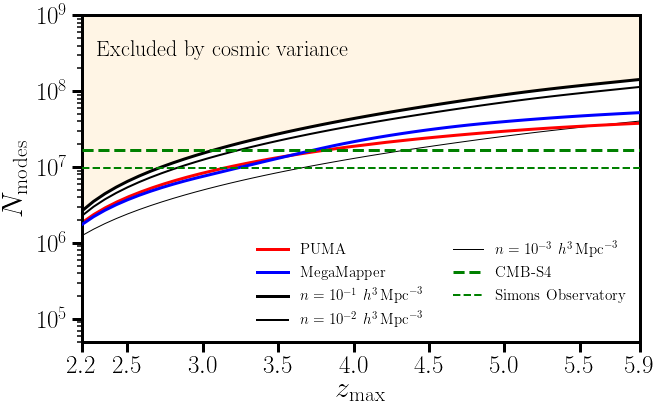

In [18]:
plt.figure(figsize=(10,6))
plt.semilogy(puma_zmax,puma_Nmodes+desi_Nmodes,c='r',lw=3.,label='PUMA',zorder=2)
plt.semilogy(mega_zmax,mega_Nmodes+desi_Nmodes,c='b',lw=3.,label='MegaMapper',zorder=3)
#plt.semilogy(mega_zmax,mega_kpar_Nmodes,c='cyan',lw=2.,label=r'MegaMapper, $k^\parallel_\text{min}=0.01$ $h/$Mpc',zorder=3)
plt.semilogy(mega_zmax,NGH4_Nmodes+desi_Nmodes,c='k',lw=3.,label=r'$n=10^{-1}$ $h^3\,{\rm Mpc}^{-3}$',zorder=1)
plt.semilogy(mega_zmax,NGH2_Nmodes+desi_Nmodes,c='k',lw=2.,label=r'$n=10^{-2}$ $h^3\,{\rm Mpc}^{-3}$',zorder=1)
plt.semilogy(mega_zmax,NGH1_Nmodes+desi_Nmodes,c='k',lw=1.,label=r'$n=10^{-3}$ $h^3\,{\rm Mpc}^{-3}$',zorder=1)

plt.semilogy(puma_zmax,S4*np.ones(len(puma_zmax)),lw=3,ls='--',color='green',label='CMB-S4',zorder=4)
plt.semilogy(puma_zmax,SO*np.ones(len(puma_zmax)),lw=2,ls='--',color='green',label='Simons Observatory',zorder=4)

plt.fill_between(puma_zmax,cv_Nmodes+desi_Nmodes,upper_limit,color='orange',alpha=0.1)

plt.text(2.3,3.e8,'Excluded by cosmic variance')

plt.xticks(ticks=[2.2,2.5,3.,3.5,4.,4.5,5.,5.5,5.9])

plt.xlabel(r'$z_\text{max}$')
plt.ylabel(r'$N_\text{modes}$')
plt.legend(loc='lower right',fontsize='x-small',frameon=False,ncol=2)
plt.xlim(2.2,5.9)
plt.ylim(5.e4,1.e9)
plt.savefig('figures/fom.pdf',bbox_inches='tight')

# $b^2 n$ as a function of redshift for various samples

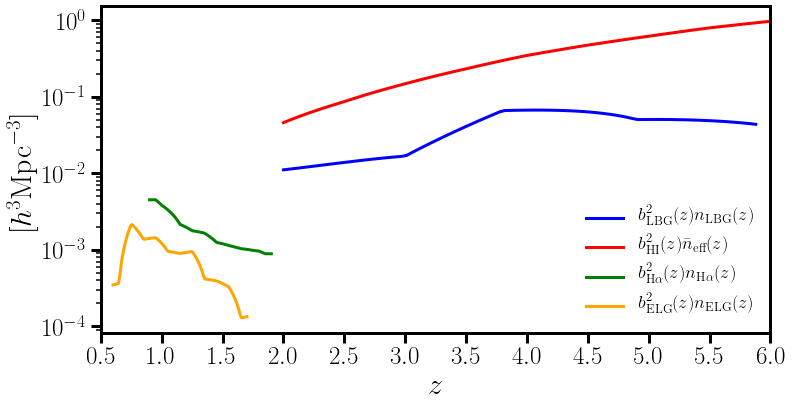

In [20]:
zs = np.array([0.9,1.,1.2,1.4,1.6,1.8,1.9])
b = np.array([1.05,1.05,1.17,1.30,1.44,1.6,1.6])
b_interp = interp1d(zs, b, kind='linear', bounds_error=False, fill_value=0.)

from twoPoint import *
from twoPointNoise import *

zz = np.linspace(2.,6.,100)
LBGbias = np.array([LBGb(z) for z in zz])
LBGnumber_density = np.array([LBGn(megaCast, z) for z in zz])
HIbias = np.array([HIb(z) for z in zz])
HInumber_density = np.array([HIneff(z) for z in zz])

zz_low = np.linspace(0.9,1.9,100)
HalphaBias = np.array([hAlphaB(z) for z in zz_low])
Halphanumber_density = np.array([hAlphaN(megaCast, z) for z in zz_low])

zz_lower = np.linspace(0.6,1.7,100)
ELGbias = np.array([ELGb(megaCast,z) for z in zz_lower])
ELGnumber_density = np.array([ELGn(megaCast,z) for z in zz_lower])

plt.figure(figsize=(12,6))
plt.semilogy(zz[:-3],LBGnumber_density[:-3]*LBGbias[:-3]**2.,c='b',lw=3,label=r'$b^2_\text{LBG}(z)n_\text{LBG}(z)$')
plt.semilogy(zz,HInumber_density*HIbias**2.,c='r',lw=3,label=r'$b^2_\text{HI}(z)\bar{n}_\text{eff}(z)$')
plt.semilogy(zz_low,Halphanumber_density*HalphaBias**2.,c='green',lw=3,label=r'$b^2_{\text{H}\alpha}(z)n_{\text{H}\alpha}(z)$')
plt.semilogy(zz_lower,ELGnumber_density*ELGbias**2.,c='orange',lw=3,label=r'$b^2_\text{ELG}(z)n_\text{ELG}(z)$')
plt.xlabel(r'$z$')
plt.ylabel(r'[$h^3$\text{Mpc}$^{-3}$]')
plt.legend(loc='lower right',frameon=False,fontsize='small')
plt.xlim(0.5,5.6)
plt.xticks(ticks=[0.5,1.,1.5,2.0,2.5,3.,3.5,4.,4.5,5.,5.5,6.])
plt.savefig('figures/b2n.pdf',bbox_inches='tight')

# Planck
in [‘Omega_cdm’, ‘Omega_b’, ‘A_s’, ‘n_s’, ‘h’, ‘tau_reio’, ‘m_nu’, ‘w_0’, ‘w_a’, ‘Omega_k’] basis

In [80]:
Plank = np.genfromtxt('output/SimoFisher_Planck_LB_June12.txt')

in ['h','A_s','Omega_cdm','n_s','Omega_b','tau_reio','m_ncdm','fEDE','f_NL','b','N'] basis

In [81]:
Plank_newbasis = np.zeros((11,11))
mapping = {0:4,1:2,2:0,3:3,4:1,5:5,6:6}
for i in range(7):
    for j in range(7):
        Plank_newbasis[i,j] = Plank[mapping[i],mapping[j]]

in ['h','log(A_s)','omega_cdm','n_s','omega_b','tau_reio','m_ncdm','fEDE','f_NL','b','N'] basis

In [82]:
Plank = Plank_newbasis.copy()
Plank[1,:] *= pumaParams['A_s']
Plank[:,1] *= pumaParams['A_s']
Plank[2,:] /= pumaParams['h']**2.
Plank[:,2] /= pumaParams['h']**2.
Plank[4,:] /= pumaParams['h']**2.
Plank[:,4] /= pumaParams['h']**2.

# One parameter constraints

In [83]:
Plank_reduced = Plank.copy()
Plank_reduced = np.delete(Plank_reduced,8,0)
Plank_reduced = np.delete(Plank_reduced,8,1)
Plank_reduced = np.delete(Plank_reduced,6,0)
Plank_reduced = np.delete(Plank_reduced,6,1)

In [73]:
def get_marginalized_error(F,basis,param):
   result = F.copy()
   index = np.where(basis == param)[0][0]
   print(index)
   n = len(basis)
   for i in np.flip(range(index+1,n)):
      result = np.delete(result,i,0)
      result = np.delete(result,i,1)
   for i in np.flip(range(9,index)):
      result = np.delete(result,i,0)
      result = np.delete(result,i,1)
   print(len(result))
   return np.sqrt(np.linalg.inv(result+Plank_reduced)[9,9])

In [74]:
F_puma = np.genfromtxt('output/F_puma.txt')

In [79]:
get_marginalized_error(F_puma,pumaCast.marg_params,'f_NL_eq')

12
10


0.03550669005077049

In [61]:
F_puma = np.genfromtxt('output/F_megamapper.txt')[:9,:9]

In [64]:
np.sqrt(np.linalg.inv(F_puma+Plank_reduced)[3,3])

0.0005398574555757843

# Posterior plots

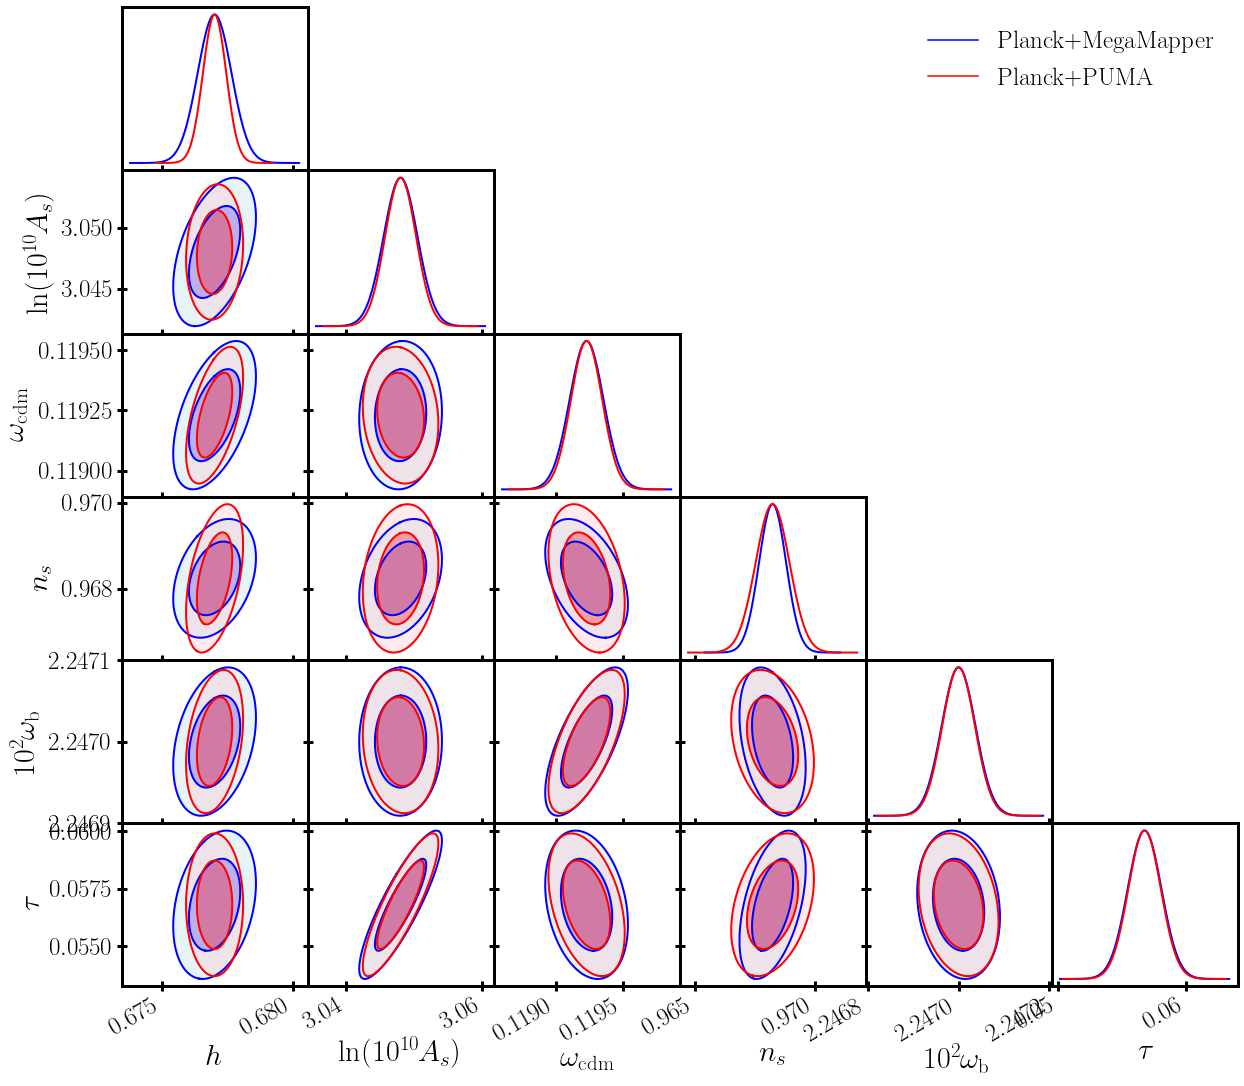

In [86]:
n = 6
# standard cosmological parameters + fEDE + b + N
F_megamapper_reduced = np.genfromtxt('output/F_megamapper.txt')[:9,:9]
F_puma_reduced = np.genfromtxt('output/F_puma.txt')[:9,:9]


# change from omega_b to 10^{-2} omega_b basis
F_megamapper_reduced[4,:] /= 100.
F_megamapper_reduced[:,4] /= 100.
F_puma_reduced[4,:] /= 100.
F_puma_reduced[:,4] /= 100.

# fiducial values
FID_VAL = np.array([0.6770,np.log(2.10732e-9)+np.log(10.**10.),0.11923,0.96824,0.02247*100.,0.0568,0.])
LABELS = np.array([r'$h$',r'$\ln(10^{10}A_s)$',r'$\omega_\text{cdm}$',r'$n_s$',r'$10^2\omega_\text{b}$',r'$\tau$',r'$f_\text{EDE}$'])

fig, axs = plt.subplots(n,n,figsize=(20,20),gridspec_kw={'hspace': 0.,'wspace':0.})

for i in range(n):
   for j in range(n):
      axs[i,j].tick_params(direction='inout')
      if i<j: axs[i,j].axis('off')
      if i>=j and j!=0: axs[i,j].yaxis.set_ticklabels([])
      if i==j: axs[i,j].yaxis.set_visible(False)
        
for j in range(n-1):
   for i in range(j,n): 
      axs[i,j].get_shared_x_axes().join(axs[i,j],axs[n-1,j])   

for j in range(1,n):
   for i in range(j): 
      axs[j,i].get_shared_y_axes().join(axs[j,i],axs[j,0])
        
def plot_ellipse(F,i,j,cs):
   Finv = np.linalg.inv(F)
   Ginv = np.array([[Finv[i,i],Finv[i,j]],[Finv[i,j],Finv[j,j]]])
   G = np.linalg.inv(Ginv)
   eigenvals,S = np.linalg.eig(G)
   D = np.diag(eigenvals)
   # find the solution of the ellipse in the diagonal basis
   theta = np.linspace(0.,2.*np.pi,1000)
   for k,f in enumerate(np.array([0.167,0.434])):
      xprime = np.cos(theta) / np.sqrt(f * D[0,0])
      yprime = np.sin(theta) / np.sqrt(f * D[1,1])
      # transform back to the parameter basis
      x,y = np.dot(S, np.array([xprime,yprime]))
      fid_val1 = FID_VAL[i]
      fid_val2 = FID_VAL[j]
      x += fid_val1
      y += fid_val2
      axs[i,j].fill(y,x,c=cs[k],alpha=0.3)
      axs[i,j].plot(y,x,c=cs[-1],lw=2)
    
def plot_gaussian(F,i,c):
    Finv = np.linalg.inv(F)
    sigma = np.sqrt(Finv[i,i])
    fid_val = FID_VAL[i]
    domain = np.linspace(fid_val-5.*sigma,fid_val+5.*sigma,100)
    gauss = np.exp(- (domain-fid_val)**2./(2.*sigma**2.))
    axs[i,i].plot(domain,gauss,c=c,lw=2)
    
for i in range(n): 
   plot_gaussian(Plank_reduced+F_megamapper_reduced,i,'blue')
   plot_gaussian(Plank_reduced+F_puma_reduced,i,'red')
   #plot_gaussian(F_megamapper+F_puma,i,'green')
    
for i in range(n-1):
   for j in range(1+i,n):
      plot_ellipse(Plank_reduced+F_megamapper_reduced,j,i,['lightblue','blue'])
      plot_ellipse(Plank_reduced+F_puma_reduced,j,i,['pink','red'])
      #plot_ellipse(F_megamapper+F_puma,j,i,['lightgreen','green'])
    
#axs[5,0].set_ylim(0,0.07)  
#axs[n-1,5].set_xlim(0,0.07)
#axs[6,0].set_ylim(0,0.012)  
#axs[n-1,6].set_xlim(0,0.012)
#axs[n-1,1].set_xlim(3.03,3.07)
#axs[n-1,2].set_xlim(0.116,0.122)

for i in range(n): 
  axs[i,0].set_ylabel(LABELS[i])
  axs[n-1,i].set_xlabel(LABELS[i])
    
for i in range(n-1): axs[i,0].xaxis.set_ticklabels([])

axs[0,n-1].plot([],[],c='blue',label='Planck+MegaMapper')
axs[0,n-1].plot([],[],c='red',label='Planck+PUMA')
#axs[0,n-1].plot([],[],c='green',label='MegaMapper+PUMA')
axs[0,n-1].legend(loc=0,frameon=False)
fig.autofmt_xdate()
plt.savefig('figures/posterior_matrix.pdf',bbox_inches='tight')

# Constraining distance scales

In [65]:
def marginalized_uncertainty(fishcast,param,zbin_index):
   fishcast.marg_params = np.array(['h','log(A_s)','omega_cdm','n_s','omega_b','tau_reio','b','N',param])
   F = fishcast.compute_Fisher_matrix_for_specific_zbin(zbin_index)
   z = fishcast.experiment.zcenters[zbin_index]
   if param == 'Da': fidval = fishcast.cosmo.angular_distance(z)
   if param == 'Hz': fidval = fishcast.cosmo.Hubble(z)*(299792.458)/fishcast.params['h']
   Finv = np.linalg.inv(F+Plank_reduced)
   return np.sqrt(Finv[-1,-1])/fidval

In [66]:
sigma_Hz_megamapper = [marginalized_uncertainty(megaCast,'Hz',i) for i in range(len(megaCast.experiment.zcenters))]
sigma_Da_megamapper = [marginalized_uncertainty(megaCast,'Da',i) for i in range(len(megaCast.experiment.zcenters))]

In [67]:
sigma_Hz_puma = [marginalized_uncertainty(pumaCast,'Hz',i) for i in range(len(pumaCast.experiment.zcenters))]
sigma_Da_puma = [marginalized_uncertainty(pumaCast,'Da',i) for i in range(len(pumaCast.experiment.zcenters))]

/home/noah/Documents/Berkeley/fishlss/fisherForecast.py:225: RuntimeWarning: divide by zero encountered in true_divide
  wedge = kparallel/kperpendicular > chi*Hz*np.sin(theta_w)/(c*(1.+z))


Text(0.5, 0, '$z$')

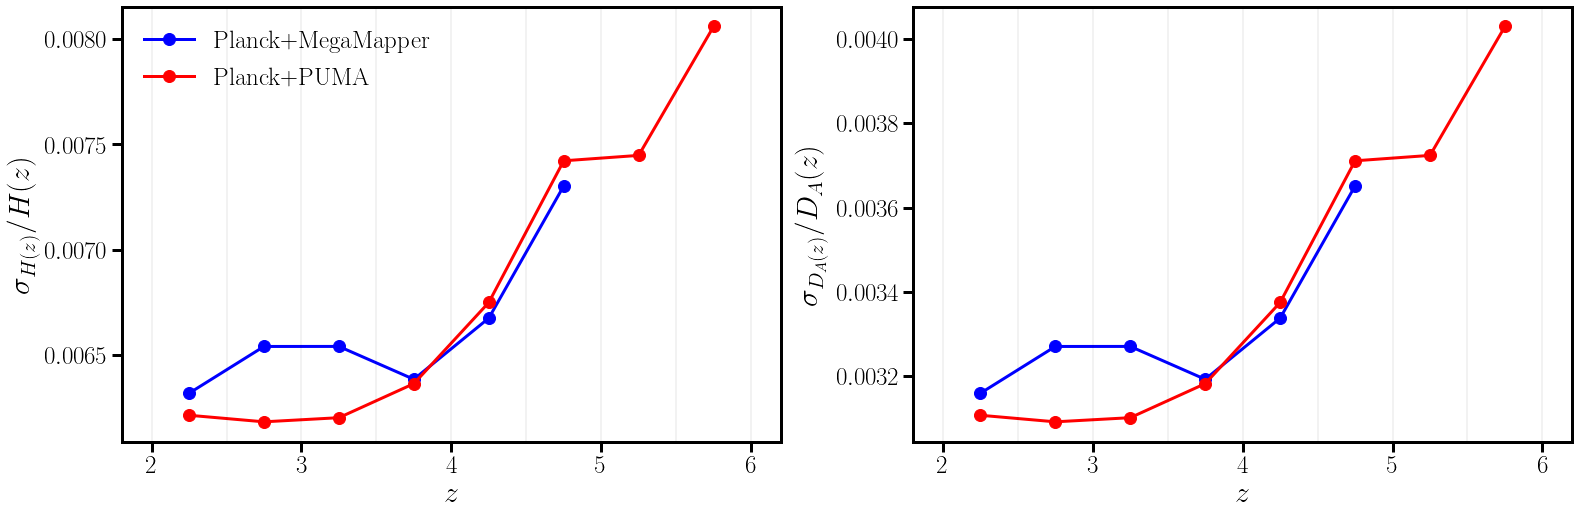

In [77]:
fig, axs = plt.subplots(1,2,figsize=(26,8))

axs[0].plot(megaCast.experiment.zcenters,sigma_Hz_megamapper,lw=3,label='Planck+MegaMapper',color='b',marker='o',markersize=12)
axs[0].plot(pumaCast.experiment.zcenters,sigma_Hz_puma,lw=3.,ls='-',label='Planck+PUMA',color='r',marker='o',markersize=12)
for z in pumaCast.experiment.zedges: axs[0].axvline(z,color='k',lw=0.1)
axs[0].set_ylabel(r'$\sigma_{H(z)}/H(z)$')
axs[0].set_xlabel(r'$z$')
axs[0].legend(loc=2,frameon=False)

axs[1].plot(megaCast.experiment.zcenters,sigma_Da_megamapper,lw=3,color='b',marker='o',markersize=12)
axs[1].plot(pumaCast.experiment.zcenters,sigma_Da_puma,lw=3.,color='r',marker='o',markersize=12)
for z in pumaCast.experiment.zedges: axs[1].axvline(z,color='k',lw=0.1)
axs[1].set_ylabel(r'$\sigma_{D_A(z)}/D_A(z)$')
axs[1].set_xlabel(r'$z$')

plt.savefig('figures/Hz_Da.pdf',bbox_inches='tight')

# Uncertainty of $f_\text{EDE}$ as a function of $z_c$

In [79]:
pumaCast.marg_params = np.array(['h','log(A_s)','omega_cdm','n_s','omega_b','tau_reio','fEDE','b','N'])
megaCast.marg_params = np.array(['h','log(A_s)','omega_cdm','n_s','omega_b','tau_reio','fEDE','b','N'])

sigma_f_EDE_megamapper = []
sigma_f_EDE_puma = []
log10z_cs = np.linspace(1.5,6.5,30)

for i,log10z_c in enumerate(log10z_cs):
   megaCast.log10z_c = log10z_c
   pumaCast.log10z_c = log10z_c
   Fisher_megamapper = megaCast.compute_Fisher_matrix() 
   Fisher_puma = pumaCast.compute_Fisher_matrix() 
   sigma_f_EDE_megamapper.append(np.sqrt(np.linalg.inv(Fisher_megamapper+Plank_reduced)[6,6]))
   sigma_f_EDE_puma.append(np.sqrt(np.linalg.inv(Fisher_puma+Plank_reduced)[6,6]))

In [80]:
sigma_f_EDE_megamapper = np.array(sigma_f_EDE_megamapper)
sigma_f_EDE_puma = np.array(sigma_f_EDE_puma)

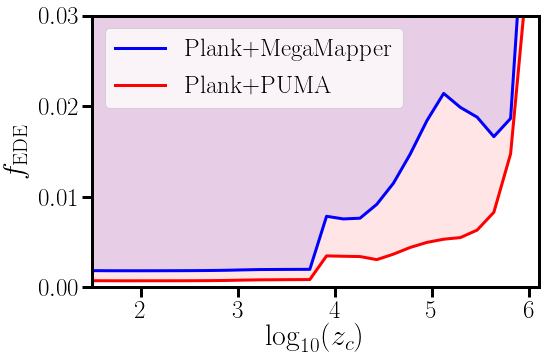

In [94]:
# here I'm plotting the 95% exclusion
plt.figure(figsize=(8,5))
plt.plot(log10z_cs,2.*sigma_f_EDE_megamapper,c='b',lw=3,label='Planck+MegaMapper')
plt.fill_between(log10z_cs,2.*sigma_f_EDE_megamapper,10.*np.ones(len(log10z_cs)),color='b',alpha=0.1)
plt.plot(log10z_cs,2.*sigma_f_EDE_puma,c='r',label='Planck+PUMA',lw=3)
plt.fill_between(log10z_cs,2.*sigma_f_EDE_puma,10.*np.ones(len(log10z_cs)),color='r',alpha=0.1)
plt.ylabel(r'$f_\text{EDE}$')
plt.xlabel(r'$\log_{10}(z_c)$')
plt.xlim(log10z_cs[0],log10z_cs[-1])
plt.ylim(0.,0.03)
plt.xlim(1.5,6.1)
plt.legend(loc=2)
plt.savefig('figures/fEDE_exclusion.pdf',bbox_inches='tight')

# Uncertainty of $A_\text{lin}$ as a function of $\omega_\text{lin}$

In [ ]:
pumaCast.marg_params = np.array(['h','log(A_s)','omega_cdm','n_s','omega_b','tau_reio','A_lin','b','N'])
megaCast.marg_params = np.array(['h','log(A_s)','omega_cdm','n_s','omega_b','tau_reio','A_lin','b','N'])

sigma_f_Alin_megamapper = []
sigma_f_Alin_puma = []
omega_lin = np.linspace(0.001,1.,30) #CHANGE THIS

for i,omega_lin in enumerate(omega_lin):
   megaCast.omega_lin = omega_lin
   pumaCast.omega_lin = omega_lin
   Fisher_megamapper, = megaCast.compute_Fisher_matrix() 
   Fisher_puma, = pumaCast.compute_Fisher_matrix() 
   sigma_f_EDE_megamapper.append(np.sqrt(np.linalg.inv(Fisher_megamapper+Plank_reduced)[6,6]))
   sigma_f_EDE_puma.append(np.sqrt(np.linalg.inv(Fisher_puma+Plank_reduced)[6,6]))